# Maxcut with Qiskit

<div>
<img src="maxcut_to_ising.png" width="900"/>
</div>

### Construct the graph

In [1]:
import networkx as nx

graph = nx.Graph()
graph.add_weighted_edges_from([
    (0, 1, 1), (1, 2, 3), (2, 3, 2),
    (3, 4, 1), (4, 0, 3), (1, 4, 4)
])

### Get the Hamiltonian

In [2]:
from qiskit_optimization.applications import Maxcut

maxcut = Maxcut(graph)
quadratic_program = maxcut.to_quadratic_program()
hamiltonian, offst = quadratic_program.to_ising()
print(hamiltonian)

0.5 * IIIZZ
+ 1.5 * IIZZI
+ 1.0 * IZZII
+ 1.5 * ZIIIZ
+ 2.0 * ZIIZI
+ 0.5 * ZZIII


### Choose the ansatz

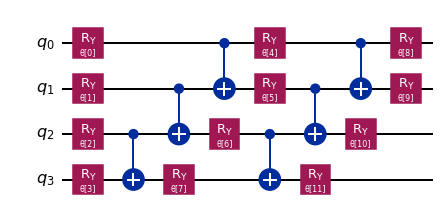

In [3]:
from qiskit.circuit.library import RealAmplitudes

ansatz = RealAmplitudes(num_qubits=4, reps=2)
ansatz.decompose().draw("mpl", style="iqx")

### Setup VQE

We need to set the `Estimator` to evaluate expectation values and a classical optimizer. Here we choose `COBYLA`.

In [4]:
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import COBYLA
from qiskit.algorithms.minimum_eigensolvers import VQE

estimator = Estimator()
optimizer = COBYLA()

vqe = VQE(estimator, ansatz, optimizer)

Now we can run the VQE!

In [5]:
result = vqe.compute_minimum_eigenvalue(hamiltonian)

And we're interested in the final state, so we use the `Sampler` to sample from the final distribution.

In [6]:
from qiskit.primitives import Sampler

optimal_state = ansatz.bind_parameters(result.optimal_parameters)
optimal_state.measure_all()

sampler = Sampler(options={"shots": 1024})
distribution = sampler.run([optimal_state]).result().quasi_dists[0]

Plotting it tells us, which state is the most likely solution.

State, Probability
('10100', 0.9990234375)


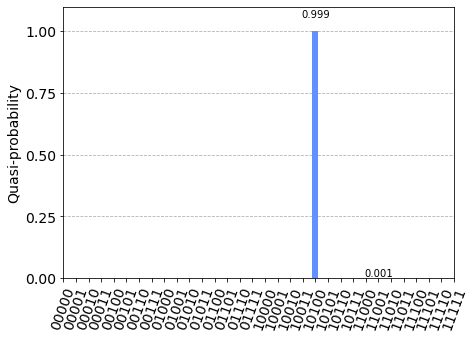

In [7]:
from qiskit.visualization import plot_histogram

solution = max(distribution.binary_probabilities().items(), key=lambda x: x[1])
print("State, Probability")
print(solution)
plot_histogram(distribution.binary_probabilities())

And indeed it matches our expectation!

In [8]:
for i, group in enumerate(reversed(solution[0])):
    print(f"Node {i}: {group}")

Node 0: 0
Node 1: 0
Node 2: 1
Node 3: 0
Node 4: 1


<div>
<img src="cut.png" width="400"/>
</div>